* # Multi-label classification using neural networks with a regularization

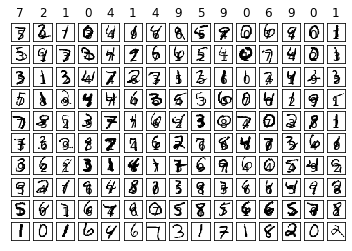

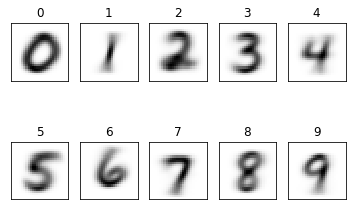

(10000,)
(784, 10000)


In [2]:
import matplotlib.pyplot as plt
import numpy as np

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1

#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


#plt.show()

#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()
print(list_label.shape)
print(list_image.shape)

* ## Define each fuctions

In [3]:
# sigmoid function
def sigmoid(z):
    return 1/(1 + np.exp(-1*z))

# derivation of sigmoid
def dsigmoid(z):
    t = sigmoid(z)
    return t*(1-t)

# structure of fully connected layer
def pipeline(x, u, v, w, b_u, b_v, b_w):
    y__ = np.dot(u, x) + b_u
    yo = sigmoid(y__)
    z__ = np.dot(v, yo) + b_v
    zo = sigmoid(z__)
    h__ = np.dot(w, zo) + b_w
    ho = sigmoid(h__)
    
    return y__, yo, z__, zo, h__, ho

# calculating loss
def j(h, label, m):
    tmp = (-1*label*np.log(h)) - ((1-label)*np.log(1-h))
    total = np.sum(tmp)
    return total/m


# calculate each parameters derivative
def descending(x_, y_, y, z_, z, h_, h , u, v, w, label):
    dj_dh = (-1*label/(h)) + ((1-label)/(1-h)) 
    dh_dh = dsigmoid(h_)
    dh_dw = z
    tmp0 = dj_dh * dh_dh
    dw = np.dot(tmp0, dh_dw.T)
    db_w = np.sum(dw, axis=1)
    
    tmp1 = np.dot(w.T, tmp0)
    tmp2 = tmp1 * dsigmoid(z_)
    dv = np.dot(tmp2, y.T)
    db_v = np.sum(dv, axis = 1)
    
    tmp3= np.dot(v.T, tmp2)
    tmp4 = tmp3 * dsigmoid(y_)
    du = np.dot(tmp4, x_.T)
    db_u = np.sum(du, axis=1)
    
    return dw, dv, du, db_w, db_v, db_u


# checking accuracy
def accuracy(h, label, m):
    prediction = []
    answer = []
    tmp0 = []
    tmp1 = []
    count = 0
    for i in range(m):
        tmp0 = h[:,i]
        tmp1 = label[:,i]
        prediction.append(np.argmax(tmp0))
        answer.append(np.argmax(tmp1))
    for t in range(len(prediction)):
        if prediction[t]==answer[t]:
            count+=1
    return (count*100)/len(prediction)


def classification(x_, h, label, m):
    prediction = []
    answer = []
    correct = []
    correct_data = []
    miss = []
    miss_data = []
    tmp0 = []
    tmp1 = []
    for i in range(m):
        tmp0 = h[:,i]
        tmp1 = label[:,i]
        prediction.append(np.argmax(tmp0))
        answer.append(np.argmax(tmp1))
        
    for t in range(len(prediction)):
        if prediction[t]==answer[t]:
            correct.append(h[:,t])
            correct_data.append(x_[:,t])
        else:
            miss.append(h[:,t])
            miss_data.append(x_[:,t])
    return correct, miss, correct_data, miss_data


    

## 0. optimizing data 

In [54]:
m = 9000
f_m = 1000
x_ = list_image[:,0:9000]
f_x_ = list_image[:,9000:10000]
tmp = list_label[0:9000]
lamb = 0.1
# t_label is extended train label by (10,6000) 
t_label = np.zeros((10, 9000))

for i in range (0,9000):
    l = tmp[i]
    t_label[l,i] = 1
    i+=1
    
# f_label is extended test label by (10,4000)
fmp =list_label[9000:10000]
f_label = np.zeros((10,1000))
for i in range (0,1000):
    l = fmp[i]
    f_label[l,i] = 1
    i+=1

# training weight
u = np.random.randn(196, 784)
v = np.random.randn(49, 196)
w = np.random.randn(10, 49)


# training bias
b_u = np.random.randn(196,1)
b_v = np.random.randn(49,1)
b_w = np.random.randn(10,1)

step = 0.0001

count = 0
count_list = []
loss_list = []
f_loss_list = []
accuracy_list = []
f_accuracy_list= []
enough = False

while enough == False:
    
    if count == 2000:
        enough = True
        
    else:
        y_, y, z_, z, h_, h  = pipeline(x_, u, v, w, b_u, b_v, b_w)
        f_y_, f_y, f_z_, f_z, f_h_, f_h  = pipeline(f_x_, u, v, w, b_u,b_v, b_w)
        
        count_list.append(count)
        
        loss_t = j(h, t_label, m)
        loss_f = j(f_h, f_label, f_m)
        
        loss_list.append(loss_t)
        f_loss_list.append(loss_f)
        
        rate = accuracy(h, t_label, m)
        f_rate = accuracy(f_h, f_label, f_m)
        
        accuracy_list.append(rate)
        f_accuracy_list.append(f_rate)
        
        dw, dv, du, db_w, db_v, db_u = descending(x_, y_, y, z_, z, h_, h , u, v, w, t_label)
        
        w = w*(1-(step*lamb)/m) - step*dw
        v = v*(1-(step*lamb)/m) - step*dv
        u = u*(1-(step*lamb)/m) - step*du
        
        b_w = b_w*(1-(step*lamb)/m) - step*db_w[:,None]
        b_v = b_v*(1-(step*lamb)/m) - step*db_v[:,None]
        b_u = b_u*(1-(step*lamb)/m) - step*db_u[:,None]
        
    
        count += 1


## 1. plotting loss curve

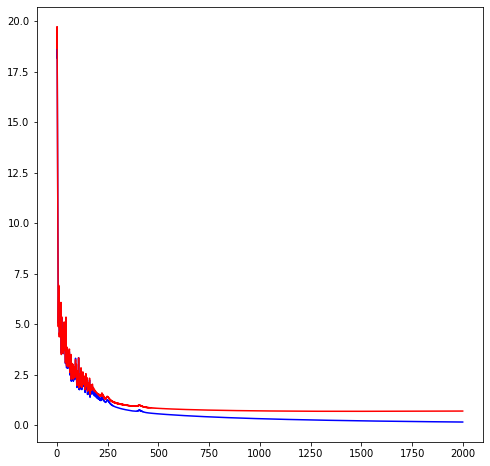

In [55]:
plt.figure(figsize=(8, 8))
plt.plot(count_list, loss_list,  color='b' )
plt.plot(count_list, f_loss_list,  color='r' )
plt.show()

## 2. plotting accuracy curve

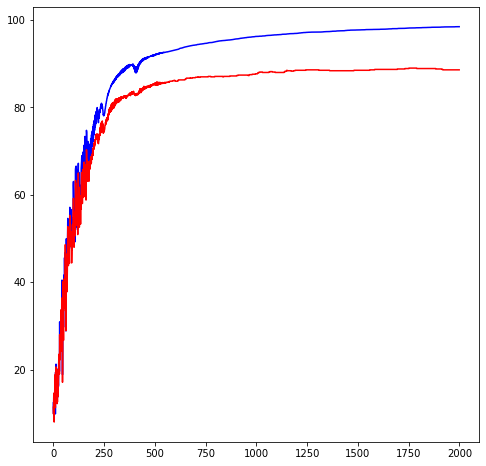

In [56]:
plt.figure(figsize=(8, 8))
plt.plot(count_list, accuracy_list,  color='b' )
plt.plot(count_list, f_accuracy_list,  color='r' )
plt.show()


## 3. plotting final accuracy

In [57]:
print("final train accuracy =", accuracy_list[-1], "%")
print("final test accuracy =", f_accuracy_list[-1], "%")

final train accuracy = 98.47777777777777 %
final test accuracy = 88.6 %


In [58]:
correct, miss, correct_data, miss_data = classification(f_x_, f_h, f_label, f_m)
correct = np.array(correct)
miss = np.array(miss)
correct_data = np.array(correct_data)
miss_data = np.array(miss_data)
# print(correct.shape, miss.shape, correct_data.shape)

correct_sample = []
miss_sample=[]
tmp0 = []
tmp1 = []
for i in range(10):
    tmp0 = correct[:,i]
    tmp1 = miss[:,i]
    maximum = np.argmax(tmp0)
    minimum = np.argmax(tmp1)
    correct_sample.append(correct_data[maximum,:])
    miss_sample.append(miss_data[minimum,:])

correct_sample = np.array(correct_sample)
miss_sample= np.array(miss_sample)



## 4-1. plotting  correctly classified testing images

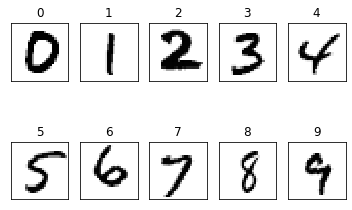

In [59]:
tmp = []
for i in range(10):

    tmp = correct_sample[i,:]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(tmp.reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


## 4-2. plotting misclassified testing images

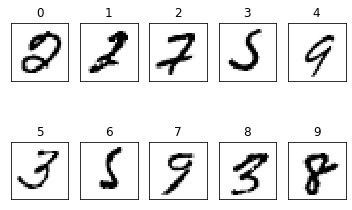

In [60]:
tmp = []
for i in range(10):

    tmp = miss_sample[i,:]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(tmp.reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)